This practical work, on motion estimation, has 3 different parts, corresponding to three families of algorithms that we have seen in class:
- Block matching algorithms
- Optic flow
- Parametric motion estimation.

You are asked to complete the different algorithms and to try it. Also, please answer to the theoretical questions, in the notebook.

In [ ]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.signal import convolve2d
#from me_ssd.py import me_ssd
#from displayMVF import displayMVF
#from fracMc import fracMc
#from PSNR import PSNR
#from me_sad import me_sad
#from HornSchunck import HS
#from applyAffineMotion import applyAffineMotion
#from angle2D import angle2D
#from gradient import gradient
#from medianFilter import medianFilter

# I - Block matching algorithms
## I-1 - Unregularized algorithms
### I-1-a - Unregularized SSD-based algorithm

First, read the two images 'flower_cif_1.mat' and 'flower_cif_1.mat', which are two consecutive frames of a video sequence. You will have to estimate the motion between these frame, using block matching algorithms.

In [ ]:
im1 = loadmat('flower_cif_1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('flower_cif_2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2e89b2b0>)

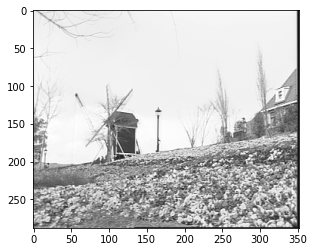

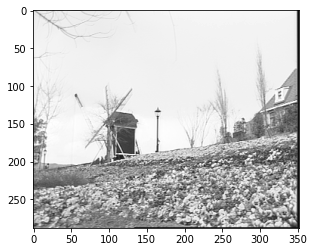

In [ ]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

First, you will have to encode a block matching using the SSD criterion. Some default values of the algorithm are given below: the number of column and rows in each block, and the search radius.

In [ ]:
brow = 16 # Number of rows per block
bcol = 16 # Number of columns per block
search_radius = 8 # Search radius

Code the me_ssd function in the me_ssd file. First, implement the unregularized function.

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 28 14:46:43 2022

@author: ckervazo
"""
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter
#%%
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_ssd(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SSD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE) # To avoid border effect
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))

    h, w = cur.shape
    
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, h, brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, w, bcol) :
                # current block selection
                B = cur[r: r + brow, c: c + bcol] # Block

                # Initialization:
                bestD = None # Meilleur déplacement

                costMin = np.inf

                Rbest = None

                
                # Loop on candidate displacement vectors
                for dcol in range(-search, search): #dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): #rcol = candidate displacement vector over the rows
                        R = ref_extended[r + extension - drow: r + extension - drow + brow, c + extension - dcol: c + extension - dcol + bcol]
                        cost = np.sum((B - R) ** 2)
                        d = np.array([drow, dcol])

                        if cost < costMin:# Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d 

                mvf[r:r+brow,c:c+bcol,0] = bestD[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestD[1]# Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest.reshape(brow, bcol)
                
    else: # Regularized search
        for r in range(0, h, brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, w, bcol) :
                # current block selection
                B = cur[r: r + brow, c: c + bcol] # Block

                # Initializations     
                bestD = None # Meilleur déplacement

                costMin = np.inf
                
                Rbest = None
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): # rcol = candidate displacement vector over the rows

                        R = ref_extended[r  + extension - drow: r  + extension - drow + brow, c + extension - dcol: c + extension - dcol + bcol]
 
                        d = np.array([drow, dcol])
                        error = np.sqrt(np.sum((d - pV)**2)) # distance euclidienne
                        cost = np.sum((B - R) ** 2) + lamb * error # here, encore the REGULARIZED cost function

                        if cost < costMin: # Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d
                
                mvf[r:r+brow,c:c+bcol,0] = bestD[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestD[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest
    
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [ ]:
mvf_ssd,prediction =  me_ssd(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Write your remarks. Are there errors? If yes, where and why?

Change the block size and the search area radius. How does it impact your results?

In [ ]:
def displayMVF(I,mvf,subsamp):
    
    row,col = np.shape(I)
    
    # Subsample dense MVF 
    vectRow = mvf[0:row:subsamp,0:col:subsamp,0]
    vectCol = mvf[0:row:subsamp,0:col:subsamp,1]
    
    # Determine vector origins
    X,Y = np.meshgrid(np.arange(0,col,subsamp),np.arange(0,row,subsamp))
    X = X + np.floor(subsamp/2.)
    Y = Y + np.floor(subsamp/2.)
    
    # Show image
    plt.figure()
    plt.imshow(I,cmap='gray')

    plt.quiver(X, Y, vectCol,-vectRow) # Signe etrange !!!!

    
    return

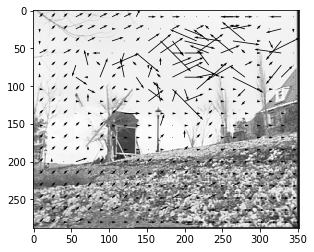

In [ ]:
displayMVF(im1,mvf_ssd,brow)

Il y a des erreurs sur le ciel qui est uniforme. L'algorithme détecte que le ciel bouge dans toutes les directions à cause du bruit. Tout le ciel est d'intensité égale donc il suffit d'un petit peu de bruit pour que l'on retrouve la même intensité 8 blocs plus loin (encore dans la fenêtre de recherche). Pour contrer ça on peut diminuer la taille de la fenêtre de recherche (pour chercher dans un périmètre plus petit ce qui limite les possibilités d'erreurs), ou ajouter un paramètre de régularisation (pour que les vecteurs de mouvements se dirigent du même sens dans un voisinage afin de n'avoir pas d'aberrations comme un pixel va à gauche et son voisin à droite). 

En effet, on remarque qu'en diminuant la taille de la fenêtre de recherche, les erreurs baissent, on obtient un résultat plus convaincant.

Motion compensation: now that we have computed the movement vector field, we can compute the motion compensated image. Display the motion compensated image. What can you observe ?

TO DO : code the motion compensation function

In [ ]:
def fracMc(ref,mvf,outofbound=20):
    
    [rows, cols] = np.shape(ref);
    
    mc_c, mc_r = np.meshgrid(np.arange(cols),np.arange(rows)) # Initial coordinates, used to infer the new coordinates
    
    mc_r_tmp = mc_r + mvf[..., 0]  # Row coordinates, after the movement
    mc_c_tmp = mc_c + mvf[..., 1] # Column coordinates, after the movement
    extension = outofbound
    ref = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REFLECT)# Padded image
    mc_r =  mc_r_tmp + extension # Row coordinates, after the movement (in the padded image)
    mc_c = mc_c_tmp + extension # Column coordinates, after the movement (in the padded image)
    
    colMeshGrid, rowMeshGrid = np.meshgrid(np.arange(cols + 2*extension), np.arange(rows + 2*extension)) # Original coordinates, in the padded image    
    
    # Put the input coordinates into the form of an array, to mach scipy format
    points = np.zeros((np.shape(ref)[0]*np.shape(ref)[1],2))
    points[:,0] = colMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    points[:,1] = rowMeshGrid.reshape(np.shape(ref)[0]*np.shape(ref)[1])
    values = ref.reshape(np.shape(ref)[0]*np.shape(ref)[1])        
    
    # Put the coordinates in which we want ot do the interpolation into the form of an array, to mach scipy format
    points_inter = np.zeros((rows*cols,2))
    points_inter[:,0] = mc_c.reshape(rows*cols)
    points_inter[:,1] = mc_r.reshape(rows*cols)
    
    motcomp = griddata(points=points, values=values, xi=points_inter)# Perform the interpolation after the movement
    
    motcomp = motcomp.reshape(rows,cols)

    return motcomp

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2e9ed040>)

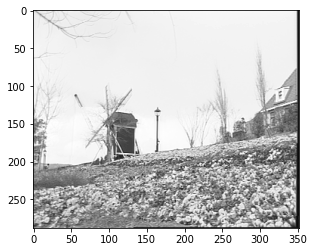

In [ ]:
mc_ssd = fracMc(im1,mvf_ssd)
plt.figure(),plt.imshow(mc_ssd,cmap='gray')

Les erreurs qu'on voyait avec les vecteurs ne se répercuttent pas sur la reconstrution car les erreurs échangent seulement deux blocs de pixels de même intensité (ou presque).

Compute the PSNR between the motion compensated and the current images.

What is the definition of PSNR ? Is the PSNR between the motion-compensated image and im2 better than between im1 and im2 ? Explain why.

Code the PSNR function. Compute it using the BM algorithm results, with different parameter values. Explain what you observe.

In [ ]:
def PSNR(im1,im2):
    """
    Computes the PSNR between im1 and im2. The two images must have the same size.

    Parameters
    ----------
    im1, im2 : nparray
        Two images.

    Returns
    -------
    psnr : float
    """
    h, w  = im1.shape
    
    eqm = np.sum((im1 - im2)**2) / (h*w)
    d = 255
    psnr = 10 * np.log10(d**2 / eqm)
    
    return psnr

In [ ]:
psnr_ssd = PSNR(im2,mc_ssd)
print(psnr_ssd)

22.70609398219703


In [ ]:
PSNR(im1, im2)

18.786509322935075

Le PSNR est définit pour une image sur 8 bit d'intensité comme étant 
$$
PSNR = 10\log_{10}(\frac{255^2}{EQM})
$$
où EQM est l'erreur quadratique moyenne.

Plus le PSNR est élevé, meilleur est la reconstruction (car proportionnel à -log(EQM))

Le PSNR entre le motion compensated image et l'image 2 est moins meilleur que celui entre l'image 1 et l'image 2: ouf! Cela veut dire qu'il y a bien une différence entre l'image 1 à l'image 2 qu'on a su en partie déduire.

Quand on augmente ou diminue la fenêtre de recherche, le résultat varie que peu

### I-1-b Unregularized SAD-based algorithm
Now, we will use the SAD as a metric for the block matching algorithm. To do that, implement the me_sad algorithm. Please note that you function should be very similar to me_ssd, except for the metric (as such, as a starting point, you can copy paste what you have proposed for me_ssd).

In [ ]:
def computePredictor(r,c,brow,bcol,mvf,ref,cur):
    """
    compute predictor gives the median of the mvf of the blocks :
        - to the left of the current block
        - above the current block
        - upper left of the current block
        
    If such blocks do not exist due to the border effects, they are not taken into account.

    Parameters
    ----------
    See usage in the me_ssd function

    Returns
    -------
    pV : Median of the mvf of the neighboor blocks

    """
    if r < brow and c < bcol:
        pV = initVector(ref,cur)
        
    elif r < brow: # First row
        pV = mvf[r,c-bcol,:]
        
    elif c < bcol: # First column
        pV = mvf[r-brow,c,:]
        
    else: # Inside
        if c >= np.shape(mvf)[1]-bcol: # Last column
            vC = mvf[r-brow,c-bcol,:]
        
        else: # Not the last column
            vC = mvf[r-brow,c+bcol,:]
            
        vA = mvf[r,c-bcol,:]
        vB = mvf[r-brow,c,:]

        temp = np.array([vA, vB, vC]).T

        pV = np.median(temp,axis = 1)
        
    pV = pV.ravel()
    
    return pV

#%%
def initVector(ref,cur):
    """
    Performs an initialization for the first regularizers

    Parameters
    ----------
    ref : np.array
        Reference image.
    cur : np.array
        Reference image.

    Returns
    -------
    pV : np.array (vector of size 2)
        Regularizer for displacement.

    """
    
    
    step = 8
    cont = 4*step
    
    REF = gaussian_filter(ref,1.) # Unclear how to set sigma
    CUR = gaussian_filter(cur,1.)
    
    CUR = CUR[cont+1:(np.shape(CUR)[0]-cont):step,cont+1:(np.shape(CUR)[1]-cont):step]
    SSDMIN = np.inf
    
    pV=np.zeros(2)
    
    for globR in range(-cont,cont):
        for globC in range(-cont,cont):
            RR = REF[cont+1-globR:(cont-globR+np.shape(CUR)[0]*step):step, cont+1-globC:(cont-globC+np.shape(CUR)[1]*step):step]
            SSD = np.sum((RR-CUR)**2)
            
            if SSD<SSDMIN:
                SSDMIN=SSD
                pV[0]=globR
                pV[1]=globC
                
                
    return pV
#%%
def me_sad(cur, ref, brow, bcol, search, lamb=0):
    """
    ME BMA full search Motion estimation
    mvf, prediction = me_ssd(cur, ref, brow, bcol, search);

    A regularization constraint can be used
    mvf = me(cur, ref, brow, bcol, search, lambda);
    In this case the function minimize SAD(v)+lambda*error(v)
    where error(v) is the difference between the candidate vector v and the
    median of its avalaible neighbors.
 
    Code inspired from the one of Marco Cagnazzo


    Parameters
    ----------
    cur : numpy array
        Current (i.e. second) frame of the video.
    ref : numpy array
        Previous (i.e. first) frame of the video.
    brow : int
        Number of rows in each block.
    bcol : int
        Number of rows in each block.
    search : int
        Search radius
    lamb : double
        Regularization parameter

    Returns
    -------
    mvf : TYPE
        DESCRIPTION.
    prediction : TYPE
        DESCRIPTION.

    """
    
    extension = search
    
    ref_extended = cv2.copyMakeBorder(ref, extension, extension, extension, extension, cv2.BORDER_REPLICATE)
    
    prediction = np.zeros(np.shape(cur));
    lamb *= brow*bcol;
    
    mvf = np.zeros((np.shape(cur)[0],np.shape(cur)[1],2))
    h, w = ref.shape
    # Non-regularized search
    if lamb == 0.:
        for r in range(0, h, brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, w, bcol) :
                # current block selection
                B = cur[r: r + brow, c: c + bcol] # Block

                # Initialization:
                bestD = None # Meilleur déplacement

                costMin = np.inf

                Rbest = None
                
                # Loop on candidate displacement vectors
                for dcol in range(-search, search): #dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): #rcol = candidate displacement vector over the rows
                        
                        R = ref_extended[r + extension - drow: r + extension - drow + brow, c + extension - dcol: c + extension - dcol + bcol]
                        cost = np.sum(np.abs(B - R))
                        d = np.array([drow, dcol])
                        
                        if cost < costMin:# Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d 
                            
                mvf[r:r+brow,c:c+bcol,0] = bestD[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1] = bestD[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol] = Rbest.reshape(brow, bcol)
                
    else: # Regularized search
         for r in range(0, h, brow) : # for each block in the current image, find the best corresponding block in the reference image
            for c in range(0, w, bcol) :
                # current block selection
                B = cur[r: r + brow, c: c + bcol] # Block

                # Initializations     
                bestD = None # Meilleur déplacement

                costMin = np.inf
                
                Rbest = None
                
                # Neighbours : pV is the regularization vector. The regularizer must be such that the estimated displacement is not too far away from pV
                pV = computePredictor(r,c,brow,bcol,mvf,ref,cur)
                
                # Loop on candidate vectors
                for dcol in range(-search, search): # dcol = candidate displacement vector over the columns
                    for drow in range(-search, search): # rcol = candidate displacement vector over the rows

                        R = ref_extended[r  + extension - drow: r  + extension - drow + brow, c + extension - dcol: c + extension - dcol + bcol]
 
                        d = np.array([drow, dcol])
                        error = np.sqrt(np.sum((d - pV)**2))
                        cost = np.sum(np.abs(B - R)) + lamb * error # here, encore the REGULARIZED cost function

                        if cost < costMin: # Save the results if they are better than the previous ones
                            Rbest = R
                            costMin = cost
                            bestD = d
                
                
                mvf[r:r+brow,c:c+bcol,0]= bestD[0] # Once the loop is over, save the best row displacement field
                mvf[r:r+brow,c:c+bcol,1]= bestD[1] # Once the loop is over, save the best column displacement field
                prediction[r:r+brow,c:c+bcol]=Rbest
                
                
    mvf = -mvf # For compatibility with standards
                            
    return mvf, prediction

In [ ]:
mvf_sad,prediction =  me_sad(im2, im1, brow, bcol, search_radius)

Show the motion vector field using the displayMVF function. Do you see any difference with the SSD ? Explain.

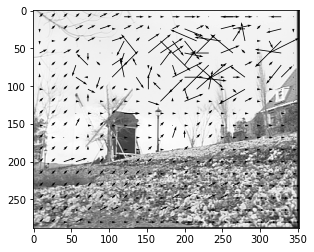

In [ ]:
displayMVF(im1,mvf_sad,brow)

On remarque un peu moins de grandes erreurs qu'avec SSD. Cela s'explique simplement par le fait que l'erreur quadratique prend énormément en compte les outliers.

Il est plus régulier que celui du SAD

Motion compensation: compute the motion compensated image and display it. In addition, compute the PSNR.

Comment the difference observed between SSD and SAD in terms of regularity of the motion vector field, PSNR of the prediction and impact of the block size.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2ebc23a0>)

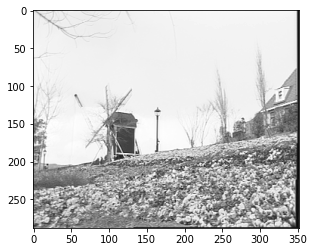

In [ ]:
mc_sad = fracMc(im1,mvf_sad)
plt.figure(),plt.imshow(mc_sad,cmap='gray')

In [ ]:
psnr_sad = PSNR(im2,mc_sad)
print(psnr_sad)

22.624556595489405


Le résultat est sensiblement le même, un peu moins bon ce qui signifient surtout que les outliers (qui sont surtout dans le ciel) ne joue pas trop de rôle là-dedans. 

Quand on diminue la taille des blocs, on affine la recherche (plus de blocs au mouvement indépendant) et donc le résultat est meilleur.



## I-2- Regularized algorithms
Now, we will add a regularization term to the metrics (SSD and then SAD) we previously used.
### I-2-1- Regularized SSD-based algorithm

TO DO : code the regularized SSD-based algorithm.
For the sake of simplicity, the regularizing function is already given. How does it work and what does it compute?

Try several parameter values, and compare your results with the unregularized algorithms. What can you observe?

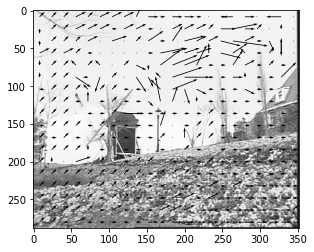

In [ ]:
mvf_ssd_reg,prediction = me_ssd(im2, im1, brow, bcol, search_radius, lamb=0.013)
displayMVF(im1,mvf_ssd_reg,brow)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2ea28820>)

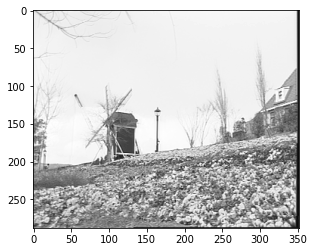

In [ ]:
mc_ssd_reg = fracMc(im1,mvf_ssd_reg)
plt.figure(),plt.imshow(mc_ssd_reg,cmap='gray')

In [ ]:
psnr_ssd_reg = PSNR(im2,mc_ssd_reg)
print(psnr_ssd_reg)

22.706010075870896


In [ ]:
# Recherche du meilleur paramètre de régularisation au sens du PSNR

lambs = [i*10**(-3) for i in range(10)]

lambBest = None
scoreBest = 0

for lamb in lambs:
  mvf_ssd_reg,prediction =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=lamb)
  mc_ssd_reg = fracMc(im1,mvf_ssd_reg)
  psnr_ssd_reg = PSNR(im2,mc_ssd_reg)
  if psnr_ssd_reg > scoreBest:
    scoreBest = psnr_ssd_reg
    lambBest = lamb

print(scoreBest)
print(lambBest)

22.70609398219703
0.0


In [ ]:
lambBest

0.0

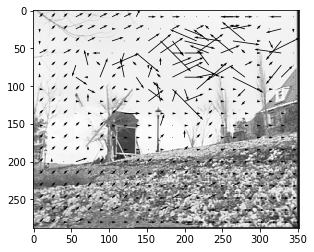

In [ ]:
mvf_ssd_reg,prediction =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=lambBest)
displayMVF(im1,mvf_ssd_reg,brow)

Avec une régularisation, les vecteurs sont pratiquement tous de même sens et de même direction, cela rajoute une régularité à ce champ de vecteurs, il y a moins de problème, notamment dans le ciel. En revanche, cela fait des mauvais résultats sur les endroits où c'est censé être statique.

### I-2-2- Regularized SAD-based algorithm

TO DO : code the regularized SAD-based algorithm.

Try several parameter values, and compare your results with the unregularized algorithms and the regularized SSD-based algorithm.

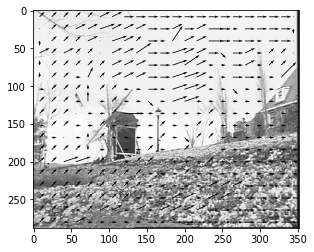

In [ ]:
mvf_sad_reg,prediction =  me_sad(im2, im1, brow, bcol, search_radius, lamb=0.05)
displayMVF(im1,mvf_sad_reg,brow)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2dc12f10>)

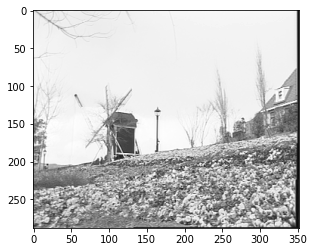

In [ ]:
mc_sad_reg = fracMc(im1,mvf_sad_reg)
plt.figure(),plt.imshow(mc_sad_reg,cmap='gray')

In [ ]:
psnr_sad_reg = PSNR(im2,mc_sad_reg)
print(psnr_sad_reg)

22.614032380828423


In [ ]:
# Recherche du meilleur paramètre de régularisation au sens du PSNR

lambs = [i*10**(-2) for i in range(10)]

lambBest = None
scoreBest = 0

for lamb in lambs:
  mvf_sad_reg,prediction =  me_sad(im2, im1, brow, bcol, search_radius, lamb=lamb)
  mc_sad_reg = fracMc(im1,mvf_sad_reg)
  psnr_sad_reg = PSNR(im2,mc_sad_reg)
  if psnr_sad_reg > scoreBest:
    scoreBest = psnr_sad_reg
    lambBest = lamb

print(scoreBest)
print(lambBest)

22.624556595489405
0.0


# Optical flow

You will now implement the Horn and Schunck algorithm to estimate the optic flow. The two images we will consider here have a more local movement vector field, since we are considering small movements in a face.

In [ ]:
im1 = loadmat('akiyo_cif1.mat')['im1']
im1 = im1.astype('float')
im2 = loadmat('akiyo_cif2.mat')['im2']
im2 = im2.astype('float')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2daea100>)

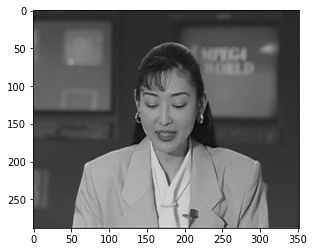

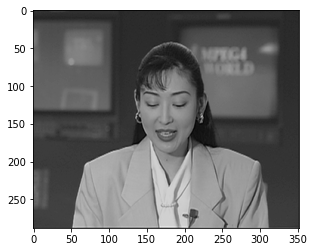

In [ ]:
plt.figure(),plt.imshow(im1,cmap='gray')
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the optical flow by filling the gaps in the Horn and Schunck function. You can use the motion field that you estimated before with the block matching algorithms to initialize you algorithm.

As a reminder, the optical flow is implemented by the iterative Horn and Schunck's algorithm:
$$
u^{n+1} = \bar{u}^n - f_x \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
$$
v^{n+1} = \bar{v}^n - f_y \frac{\bar{u}^n f_x + \bar{v}^n f_y + f_t}{\alpha^2 + \|\nabla f\|^2}
$$
where $u^n$ is the value of the $u$ component at the $n$-th iteration, and $\bar{u}$ is the local average of $u$.

In [ ]:
def computeDerivatives(im1, im2):
    kernel1D = np.expand_dims((1./12.)*np.array([-1., 8., 0., -8., 1.]),axis=1).T
    fx = convolve2d(im1,kernel1D,'same')
    fy = convolve2d(im1,kernel1D.T,'same')
    ft = convolve2d(im1, 0.25*np.ones((2,2)),'same') + convolve2d(im2, -0.25*np.ones((2,2)),'same');
    fx =-fx;
    fy=-fy;

    return fx, fy, ft


#%%
def HS(im1, im2, uInitial, vInitial, alpha=1, ite=100,blur = 1.):
    """
    Horn-Schunck optical flow method.
    Horn, B.K.P., and Schunck, B.G., Determining Optical Flow, AI(17), No. 1-3, August 1981, pp. 185-203 http://dspace.mit.edu/handle/1721.1/6337
    
    [u, v] = HS(im1, im2, alpha, ite, uInitial, vInitial, displayFlow)
    
    Parameters
    ----------
    im1, im2 : np.array
        Two subsequent frames or images.
    uInitial, vInitial: np.array
        Initial values for the (u,v) flow. If well initialized, the flow would converge faster and hence would need less iterations.
    alpha : scalar
        A parameter that reflects the influence of the smoothness term.
    ite : int
        Number of iterations.

    Returns
    -------
    u,v : np.array
        Optical flow.
    """
    
    im1 = gaussian_filter(im1,blur)
    im2 = gaussian_filter(im2,blur)
    
    # Set initial value for the flow vectors
    u = uInitial.copy()
    v = vInitial.copy()
    
    # Estimate spatiotemporal derivatives
    fx, fy, ft = computeDerivatives(im1, im2)
    
    # Averaging kernel
    kernel_1=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])
    
    for i in range(ite):
        # Compute local averages of the flow vectors using kernel_1
        uAvg = convolve2d(u, kernel_1, mode='same')
        vAvg = convolve2d(v, kernel_1, mode='same')
        
        # Compute flow vectors constrained by its local average and the optical flow constraints
        u = uAvg - fx * (uAvg*fx + vAvg*fy + ft) / (alpha**2 + fx**2 + fy**2) # Le gradient comprend-il ft ? 
        v = vAvg - fy * (uAvg*fx + vAvg*fy + ft) / (alpha**2 + fx**2 + fy**2)
        
    u[np.isnan(u)]= 0
    v[np.isnan(v)]= 0
    return u, v

In [ ]:
brow = 16; bcol=16; search_radius =13;

mvf_ssd, prediction =  me_ssd(im2, im1, brow, bcol, search_radius, lamb=0)

alpha = 100
ite = 100

uInitial = mvf_ssd[:,:, 1] # Rem: pay attention to the inversion of the order compare to me_ssd.
vInitial = mvf_ssd[:,:, 0]

[u, v] = HS(im2, im1, uInitial, vInitial, alpha, ite,blur=1.)

Display the motion field and compute the PSNR. Do you observe any improvement compare to block-matching algorithms? Explain. You can test on both the Akiyo and Flowers images.

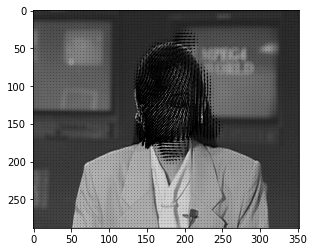

In [ ]:
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)

mc_hs = fracMc(im1,mvf_hs)
psnr_hs = PSNR(im2,mc_hs)

In [ ]:
psnr_hs

41.32807109810735

In [ ]:
PSNR(im2, im1)

34.867588879410675

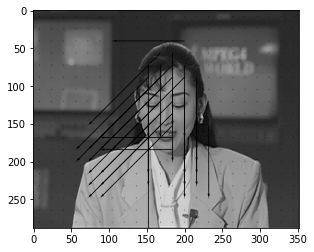

In [ ]:
mvf_ssd, prediction =  me_ssd(im2, im1, brow, bcol, search_radius)
displayMVF(im1,mvf_ssd,brow)

L'algorithme de bloc produit des mauvais résultats sur la tête qui est bouge, en mettant que seulement certaines partie de sa tête bouge alors que toute sa tête bouge. On retrouve bien le mouvement en globalité avec le flux optique.

## End of TP 1

# III - Parametric estimation
In this last part, we will work on parametric estimation, both using direct and indirect methods.
## III-1- Direct parametric estimation
### III-1-1 Theoretical questions

**Infinite signal**

Let $a: (n,m)\in \mathbb{Z}^2 \rightarrow \mathbb{R}$ be a bi-dimensional signal and $b(n,m)$ a signal of the same type.

Recall the expression of the 2D discrete time Fourier transform (DTFT).

Let us suppose that
$\exists c,d \in \mathbb{Z}^2: \forall n,m \in \mathbb{Z}^2,b(n,m) = a(n+c,m+d)$ (that is, $b$ is a translation of $a$). Compute the DTFT of $b$ as a function of the one of $a$ and of the displacement $(c,d)$.

Show that the ratio between the DTFTs is:
$$
\frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y))
$$

**Finite signal**

Now, $a: (n,m) \in \{0,1,...,N-1\}^2 \rightarrow \mathbb{R}$ and $b(n,m)$ are both finite signals. In that case, we use the Discrete Fourier Transform (DFT) rather than the DTFT.

Recall the expression of the DF.

Under which hypotheses is the ratio between $a$'s and $b$'s DFT a linear phase signal:
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N^2}\right)
$$

**Infinite signal**

The DTFT of a is:
$$\hat{a}(ν_x, ν_y) = \sum_{n=-∞}^∞\sum_{m=-∞}^∞a(n,m)e^{-i2π(nν_x + mν_y)}$$
With the properties of b we have:
$$ \begin{align} \hat{b}(ν_x, ν_y) &= \sum_{n=-∞}^∞\sum_{m=-∞}^∞b(n,m)e^{-j2π(nν_x + mν_y)} \\
&= \sum_{n=-∞}^∞\sum_{m=-∞}^∞a(n+c, m+d)e^{-i2π(nν_x + mν_y)} \\
&= \sum_{l=-∞}^∞\sum_{k=-∞}^∞a(l, k)e^{-i2π((l-c)ν_x + (k-d)ν_y)} \\
&= e^{i2π(cν_x + dν_y)}\sum_{l=-∞}^∞\sum_{k=-∞}^∞a(l, k)e^{-i2π(lν_x + kν_y)} \\
&= e^{i2π(cν_x + dν_y)}\hat{a}(ν_x, ν_y)\\
\end{align} $$
Hence we have $$ \frac{\hat{b}(\nu_x,\nu_y)}{\hat{a}(\nu_x,\nu_y)} = \exp(i2\pi (c\nu_x + d \nu_y)) $$ 

**Finite signal**

The DF of a is:
$$
\hat{A}(k_x, k_y) = \frac{1}{N^2}\sum_{n=0}^{N-1}\sum_{m=0}^{N-1}a(n,m)\exp\left(\frac{-i2π(nk_x + mk_y)}{N}\right)
$$

With the properties of b and N periodicity of all the functions we have:

$$
\begin{align}
\hat{B}(k_x, k_y) &= \frac{1}{N^2}\sum_{n=0}^{N-1}\sum_{m=0}^{N-1}b(n,m)\exp\left(\frac{-i2π(nk_x + mk_y)}{N}\right) \\
&= \frac{1}{N^2}\sum_{n=0}^{N-1}\sum_{m=0}^{N-1}a(n+c,m+d)\exp\left(\frac{-i2π(nk_x + mk_y)}{N}\right) \\
&= \frac{1}{N^2}\sum_{l=c}^{N-1+c}\sum_{k=d}^{N-1+d}a(l,k)\exp\left(\frac{-i2π((l-c)k_x + (k-d)k_y)}{N}\right) \\
&= \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)\frac{1}{N^2}\sum_{l=c}^{N-1+c}\sum_{k=d}^{N-1+d}a(l,k)\exp\left(\frac{-i2π(lk_x + kk_y)}{N}\right) \\
&= \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)\frac{1}{N^2}\sum_{l=0}^{N-1}\sum_{k=0}^{N-1}a(l,k)\exp\left(\frac{-i2π(lk_x + kk_y)}{N}\right) \\
&= \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right) \hat{A}(k_x, k_y)
\end{align}
$$

Hence we have,
$$
\frac{\hat{A}(k_x,k_y)}{\hat{B}(k_x,k_y)} = \exp\left(\frac{2i\pi(ck_x + dk_y)}{N}\right)
$$

### III-1-2 Practical part
First, start to work on the 'ball.mat' image. We will apply a translation to this image and try to estimate the parameter of the translation.

Try by either adding of not some noise into the image.

In [ ]:
im1 = loadmat('ball.mat')['im1']
im1 = im1.astype('float')

im1 = loadmat('lena.mat')['im1']
im1 = im1.astype('float')

N, M = np.shape(im1)

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2b06d400>)

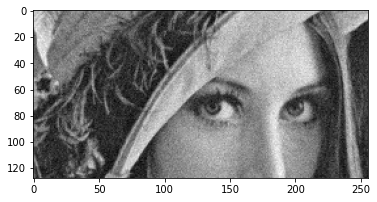

In [ ]:
# Potentially add noise to the image
sigma = 10
im1 = im1 + sigma*np.random.randn(np.shape(im1)[0],np.shape(im1)[1])
plt.figure(),plt.imshow(im1,cmap='gray')

In the following, we apply a translation to the image.

In [ ]:
def applyAffineMotion(x,b,B = np.zeros((2,2)),out = 100):
    N, M = np.shape(x)
    px, py = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1), np.arange(-(N-1)/2,(N-1)/2+1))
    
    mvfx = b[0] + B[0,0]*px + B[0,1]*py
    mvfy = b[1] + B[1,0]*px + B[1,1]*py
    
    mvf = np.zeros((np.shape(mvfx)[0],np.shape(mvfx)[1],2))
    mvf[:,:,1] = mvfx
    mvf[:,:,0] = mvfy
    
    y = fracMc(x,mvf,out)
    return y

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f0d2afbcbb0>)

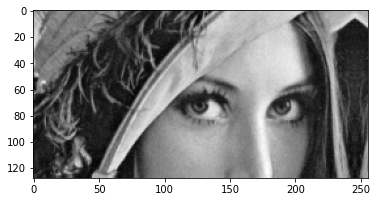

In [ ]:
horiz_displacement = 10.
vert_displacement  = 1.
b = np.array([ horiz_displacement, vert_displacement])

# We could also use an affine motion matrix
#B = np.zeros((2,2))

im2 = applyAffineMotion(im1,b)
plt.figure(),plt.imshow(im2,cmap='gray')

Compute the FFT of the two images. Using the indications given in the theroretical part, describe a method with which you can find the parameters of the translation from the two FFTs.

In [ ]:
IM1 = np.fft.fft2(im1)
IM2 = np.fft.fft2(im2)

In [ ]:
def angle2D(x):
    a = np.angle(x)
    
    b1 = np.unwrap(a,axis=0)
    b2 = np.unwrap(b1,axis=1)
    b3 = np.unwrap(a,axis=0)[:,::-1]
    b4 = np.unwrap(b3,axis=1)[:,::-1]
    
    y = (b2+b4)/2./(-2.*np.pi)
    return y

In [ ]:
phi = angle2D(IM1/IM2)

Display phi. Is it a linear plane and why?

ϕ est bien un plan linéaire, logique puisque le ratio des transformées de fourier a pour phase 2jπ multiplié par l'équation d'un plan linéaire de ce qu'on a vu dans les questions théoriques.

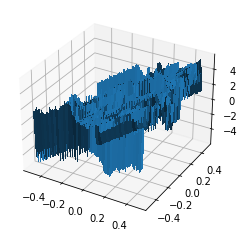

In [ ]:
fx, fy = np.meshgrid(np.arange(-(M-1)/2,(M-1)/2+1)/M, np.arange(-(N-1)/2,(N-1)/2+1)/N)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(fx, fy, phi, linewidth=0, antialiased=False)

Translation estimation: to estimate the parameters of the translation, we are now looking for the slope of the plane.

Method 1: estimate it using the median of the gradient. To do that, complete the gradient function.

In [ ]:
def gradient(M,stepX=1.,stepY=1.):
# Computes the gradient of an image, over the rows and the column directions. StepY is the assumed gap between the rows and StepX is the assumed gap between the columns
    kx = np.array([[0, 0, 0],
                   [1, 0, -1],
                   [0, 0, 0]])
    ky = kx.T
    gy = convolve2d(M, ky, mode='same') / (2*stepY)
    gx = convolve2d(M, kx, mode='same') / (2*stepX)
    
    return gx,gy

In [ ]:
gx, gy = gradient(phi,1/M,1/N)
GX = np.median(gx)
GY = np.median(gy)

In [ ]:
print(GX)
print(GY)

9.380929907640848
0.5376381664728598


Method 2: the code below computes the least Square planar approximation of phi, enabling you how to estimate the parameters of the translation. Explain how it works.

In [ ]:
from scipy.ndimage import median_filter

phi = phi-phi[int(N/2+2), int(M/2+2)]
#t = medianFilter(phi,1)
t = median_filter(phi, 1)

In [ ]:
A = np.zeros((np.shape(fx)[0]*np.shape(fx)[1],2))
A[:,0] = fx.reshape(np.shape(fx)[0]*np.shape(fx)[1])
A[:,1] = fy.reshape(np.shape(fy)[0]*np.shape(fy)[1])
b = t.reshape(np.shape(t)[0]*np.shape(t)[1])
bEst = np.dot(np.linalg.pinv(A),b)

In [ ]:
print(bEst)

[ 7.76276336e+00 -2.12177767e-03]


Relaunch the above code:
- with and without noise
- with the lena image, instead of the ball image.

Each time, are you able to correctly estimate the translation? Why? Comment your results.

# III-2-Indirect parametric estimation
In this last part, we will perform indirect parametric estimation. The movement vector field will be estimated by 1) block matching; 2) optic flow. Each time, you will then estimate the translation by taking the median of the estimated vector field.

Perform the experiment without and with noise (you can then take sigma = 2).

Finally, compare all the parametric estimation methods when the translation values are not integer.

10.0
1.0


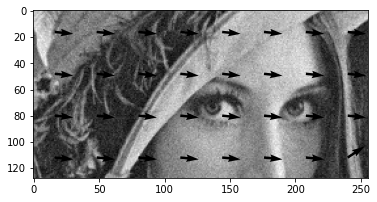

In [ ]:
lamb = 0
mvf,prediction = me_ssd(im2,im1,32,32,10,lamb)
displayMVF(im1,mvf,32)
mvf_x = mvf[:,:,1]
mvf_y = mvf[:,:,0]
bx = np.median(mvf_x)
by = np.median(mvf_y)
print(bx)
print(by)

Estimation with optic flow

5.834647400957621
0.40463686860082837


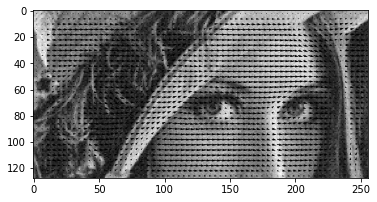

In [ ]:
alpha = 100
ite = 100
uInitial = mvf[:,:,1]
vInitial = mvf[:,:,0]
u, v = HS(im2, im1, uInitial, vInitial, alpha, ite)
mvf_hs = np.zeros((np.shape(v)[0],np.shape(v)[1],2))
mvf_hs[:,:,0] = v
mvf_hs[:,:,1] = u
displayMVF(im1,mvf_hs,4)
bx = np.median(u)
by = np.median(v)
print(bx)
print(by)

Sans la présence du bruit, l'algorithme de blocs produit des très bon résultats pour léna et le flux optique voit la bonne direction mais pas la bonne norme (/2) et pour la lune on les 2 algorithmes pensent à un déplacement diagonal.

Avec le bruit 